# Desafío Telecom X — Análisis de Evasión de Clientes (Churn)

## Objetivo
En este desafío trabajé con datos de Telecom X para aplicar un proceso ETL (Extracción, Transformación y Carga) y realizar un análisis exploratorio (EDA).  
El objetivo fue preparar un dataset limpio y obtener insights iniciales sobre factores asociados a la evasión de clientes, dejando los datos listos para un análisis predictivo posterior.

## Herramientas utilizadas
- Python
- Pandas / NumPy
- Requests
- Matplotlib
**texto en negrita**

#📌 Extracción

In [2]:
import pandas as pd
import numpy as np
import requests
import json

URL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"


In [3]:
response = requests.get(URL)
response.raise_for_status()

data = response.json()

type(data), (len(data) if isinstance(data, list) else list(data.keys())[:10])


(list, 7267)

In [4]:

if isinstance(data, list):
    records = data
elif isinstance(data, dict):

    for key in ["data", "results", "items", "clientes", "customers"]:
        if key in data and isinstance(data[key], list):
            records = data[key]
            break
    else:

        records = [data]
else:
    records = [data]

df_raw = pd.json_normalize(records, sep="_")
df_raw.head()


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [5]:
print("Filas, Columnas:", df_raw.shape)
df_raw.info()


Filas, Columnas: (7267, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSupport

In [6]:
display(df_raw.isna().sum().sort_values(ascending=False).head(15))
print("Duplicados:", df_raw.duplicated().sum())


,0
customerID,0
Churn,0
customer_gender,0
customer_SeniorCitizen,0
customer_Partner,0
customer_Dependents,0
customer_tenure,0
phone_PhoneService,0
phone_MultipleLines,0
internet_InternetService,0


Duplicados: 0


#🔧 Transformación

In [7]:
df = df_raw.copy()


df = df.replace(r"^\s*$", np.nan, regex=True)


In [8]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_", regex=False)
      .str.replace("-", "_", regex=False)
)

df.columns.tolist()[:30]


['customerid',
 'churn',
 'customer_gender',
 'customer_seniorcitizen',
 'customer_partner',
 'customer_dependents',
 'customer_tenure',
 'phone_phoneservice',
 'phone_multiplelines',
 'internet_internetservice',
 'internet_onlinesecurity',
 'internet_onlinebackup',
 'internet_deviceprotection',
 'internet_techsupport',
 'internet_streamingtv',
 'internet_streamingmovies',
 'account_contract',
 'account_paperlessbilling',
 'account_paymentmethod',
 'account_charges_monthly',
 'account_charges_total']

In [9]:
df = df.drop_duplicates()
print("Filas después de eliminar duplicados:", df.shape[0])


Filas después de eliminar duplicados: 7267


In [10]:
def try_convert_numeric(series, min_non_null_ratio=0.6):
    """Convierte a numérico si la mayoría de valores se pueden convertir."""
    converted = pd.to_numeric(series, errors="coerce")
    ratio = converted.notna().mean()
    return converted if ratio >= min_non_null_ratio else series

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = try_convert_numeric(df[col])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7267 non-null   object 
 1   churn                      7043 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_seniorcitizen     7267 non-null   int64  
 4   customer_partner           7267 non-null   object 
 5   customer_dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_phoneservice         7267 non-null   object 
 8   phone_multiplelines        7267 non-null   object 
 9   internet_internetservice   7267 non-null   object 
 10  internet_onlinesecurity    7267 non-null   object 
 11  internet_onlinebackup      7267 non-null   object 
 12  internet_deviceprotection  7267 non-null   object 
 13  internet_techsupport       7267 non-null   objec

## Exportación del dataset limpio (Load)
Finalmente, generé un archivo con los datos procesados y listos para análisis más profundos.  
Este dataset puede ser utilizado por el equipo de Data Science para entrenar modelos predictivos de churn y para profundizar en la segmentación de clientes.


#📊 Carga y análisis

In [11]:
df.to_csv("TelecomX_clean.csv", index=False)
print("Archivo generado: TelecomX_clean.csv ✅")


Archivo generado: TelecomX_clean.csv ✅


In [12]:
CHURN_COL = "churn"

print("Nulos en churn:", df[CHURN_COL].isna().sum())
display(df[CHURN_COL].value_counts(dropna=False))


Nulos en churn: 224


,count
churn,
No,5174
Yes,1869
NaN,224


In [13]:

churn_clean = df[CHURN_COL].astype(str).str.strip().str.lower()


mask_valid = churn_clean.isin(["yes", "no"])

churn_rate = (churn_clean[mask_valid] == "yes").mean()
print(f"Tasa de churn (sin nulos): {churn_rate:.2%}")
print("Registros considerados:", mask_valid.sum())


Tasa de churn (sin nulos): 26.54%
Registros considerados: 7043


In [14]:
df["churn"] = df["churn"].fillna("Unknown")
df["churn"].value_counts()


,count
churn,
No,5174
Yes,1869
Unknown,224


In [15]:
df_eda = df[df["churn"].isin(["Yes", "No"])].copy()

# variable binaria para calcular tasas fácil (1=churn, 0=no churn)
df_eda["churn_flag"] = (df_eda["churn"] == "Yes").astype(int)

print("Filas para EDA:", df_eda.shape[0])
print("Tasa churn (EDA):", f"{df_eda['churn_flag'].mean():.2%}")


Filas para EDA: 7043
Tasa churn (EDA): 26.54%


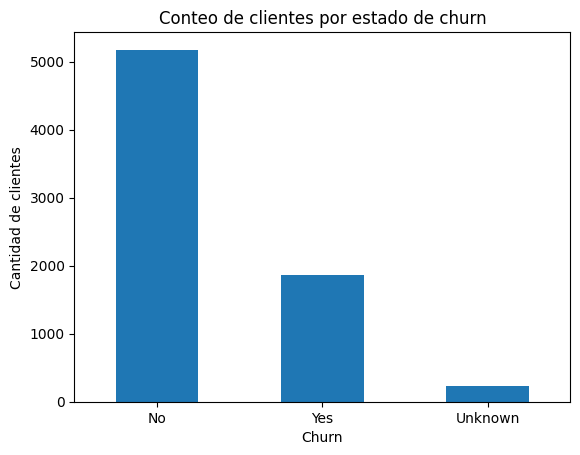

In [16]:
import matplotlib.pyplot as plt

counts = df["churn"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Conteo de clientes por estado de churn")
plt.xlabel("Churn")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.show()


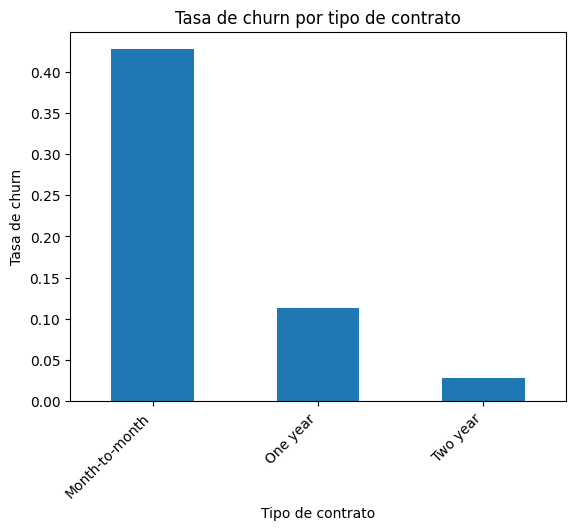

,churn_flag
account_contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


In [17]:
churn_by_contract = df_eda.groupby("account_contract")["churn_flag"].mean().sort_values(ascending=False)

plt.figure()
churn_by_contract.plot(kind="bar")
plt.title("Tasa de churn por tipo de contrato")
plt.xlabel("Tipo de contrato")
plt.ylabel("Tasa de churn")
plt.xticks(rotation=45, ha="right")
plt.show()

churn_by_contract


/tmp/ipython-input-594061881.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([no, yes], labels=["No", "Yes"])


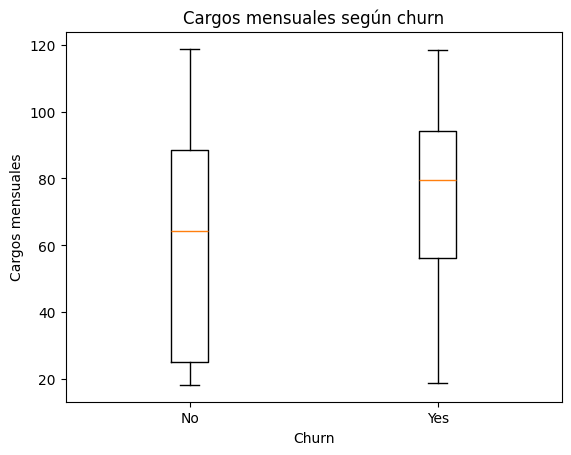

Promedio cargos mensuales (No): 61.27
Promedio cargos mensuales (Yes): 74.44


In [18]:
yes = df_eda.loc[df_eda["churn"]=="Yes", "account_charges_monthly"].dropna()
no  = df_eda.loc[df_eda["churn"]=="No",  "account_charges_monthly"].dropna()

plt.figure()
plt.boxplot([no, yes], labels=["No", "Yes"])
plt.title("Cargos mensuales según churn")
plt.xlabel("Churn")
plt.ylabel("Cargos mensuales")
plt.show()

print("Promedio cargos mensuales (No):", round(no.mean(), 2))
print("Promedio cargos mensuales (Yes):", round(yes.mean(), 2))


/tmp/ipython-input-531564094.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([no, yes], labels=["No", "Yes"])


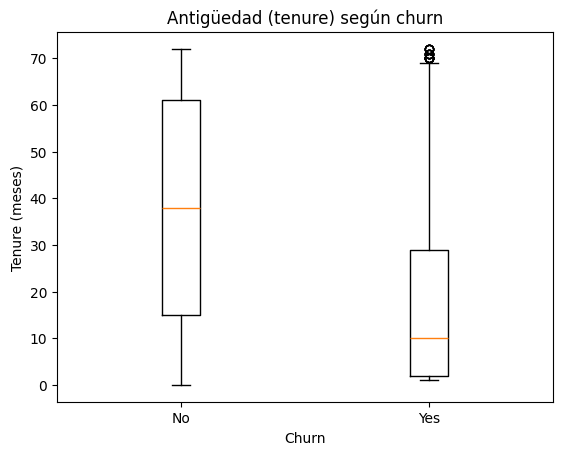

Promedio tenure (No): 37.57
Promedio tenure (Yes): 17.98


In [19]:
import matplotlib.pyplot as plt

yes = df_eda.loc[df_eda["churn"]=="Yes", "customer_tenure"].dropna()
no  = df_eda.loc[df_eda["churn"]=="No",  "customer_tenure"].dropna()

plt.figure()
plt.boxplot([no, yes], labels=["No", "Yes"])
plt.title("Antigüedad (tenure) según churn")
plt.xlabel("Churn")
plt.ylabel("Tenure (meses)")
plt.show()

print("Promedio tenure (No):", round(no.mean(), 2))
print("Promedio tenure (Yes):", round(yes.mean(), 2))


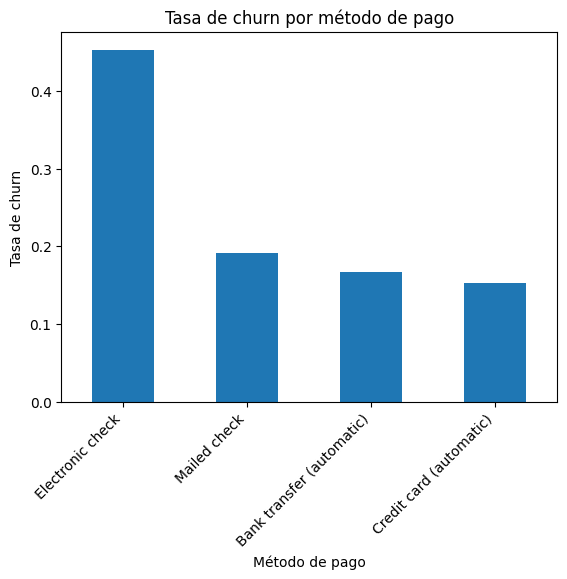

,churn_flag
account_paymentmethod,
Electronic check,0.452854
Mailed check,0.191067
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431


In [20]:
churn_by_pay = df_eda.groupby("account_paymentmethod")["churn_flag"].mean().sort_values(ascending=False)

plt.figure()
churn_by_pay.plot(kind="bar")
plt.title("Tasa de churn por método de pago")
plt.xlabel("Método de pago")
plt.ylabel("Tasa de churn")
plt.xticks(rotation=45, ha="right")
plt.show()

churn_by_pay


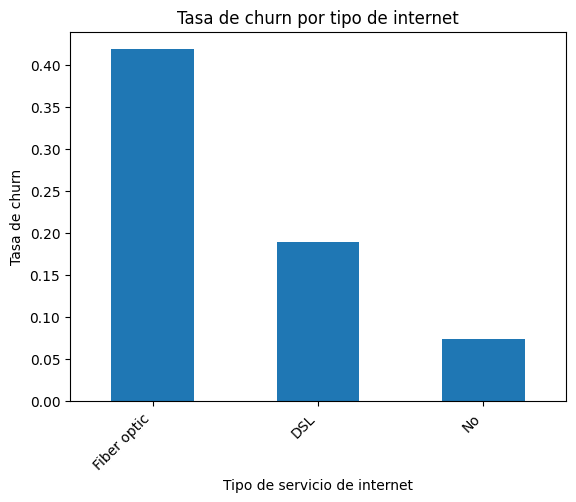

,churn_flag
internet_internetservice,
Fiber optic,0.418928
DSL,0.189591
No,0.074050


In [21]:
churn_by_internet = df_eda.groupby("internet_internetservice")["churn_flag"].mean().sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.figure()
churn_by_internet.plot(kind="bar")
plt.title("Tasa de churn por tipo de internet")
plt.xlabel("Tipo de servicio de internet")
plt.ylabel("Tasa de churn")
plt.xticks(rotation=45, ha="right")
plt.show()

churn_by_internet


In [22]:
for col in ["internet_streamingtv", "internet_streamingmovies"]:
    churn_rate_service = df_eda.groupby(col)["churn_flag"].mean().sort_values(ascending=False)
    print(f"\nTasa de churn según {col}:")
    display(churn_rate_service)



Tasa de churn según internet_streamingtv:


,churn_flag
internet_streamingtv,
No,0.335231
Yes,0.300702
No internet service,0.074050



Tasa de churn según internet_streamingmovies:


,churn_flag
internet_streamingmovies,
No,0.336804
Yes,0.299414
No internet service,0.074050


In [23]:
# Exportación final del dataset limpio
output_name = "TelecomX_clean.csv"
df.to_csv(output_name, index=False)

# Validación rápida de exportación
print("✅ Archivo exportado:", output_name)
print("Filas y columnas:", df.shape)

print("\nMuestra del dataset limpio:")
display(df.head())

print("\nResumen de churn (incluye Unknown):")
display(df["churn"].value_counts(dropna=False))


✅ Archivo exportado: TelecomX_clean.csv
Filas y columnas: (7267, 21)

Muestra del dataset limpio:


,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40



Resumen de churn (incluye Unknown):


,count
churn,
No,5174
Yes,1869
Unknown,224


#📄Informe final

# Informe final — Conclusiones e insights

## Resumen del dataset y preparación
- Se trabajó con un total de **7267 registros** y **21 variables**.
- La variable **churn** presentó **224 registros “Unknown” (~3%)**, por lo que para el análisis exploratorio utilicé solo los casos con churn conocido (**Yes/No**) para evitar sesgos.

## Hallazgos principales (EDA)
1. **Tasa de churn general (sin Unknown):**  
   Al analizar los registros con churn conocido, observé una tasa aproximada de **~26.5%** de cancelación.

2. **Tipo de contrato (factor más marcado):**  
   Identifiqué que el churn se concentra en clientes con contrato **Month-to-month (~42.7%)**, mientras que en **One year (~11.3%)** y **Two year (~2.8%)** la evasión es significativamente menor.  
   Esto sugiere que la permanencia contractual funciona como un factor de retención.

3. **Cargos mensuales y churn:**  
   Noté que los clientes que cancelan (*churn = Yes*) tienden a tener **cargos mensuales más altos** (promedio **~74.44**) en comparación con quienes permanecen (promedio **~61.27**).  
   Esto podría reflejar sensibilidad al precio o percepción de bajo valor frente al costo.

4. **Antigüedad (tenure) y churn:**  
   Observé una diferencia clara en permanencia: los clientes que no cancelan presentan un tenure promedio de **~37.6 meses**, mientras que los que cancelan promedian **~18.0 meses**.  
   Esto sugiere que la evasión ocurre con mayor frecuencia en los primeros meses de relación con la empresa.

5. **Método de pago:**  
   El churn más alto aparece en **Electronic check (~45.3%)**, mientras que los métodos automáticos presentan tasas menores (por ejemplo, **Credit card (automatic) ~15.2%**).  
   Esto podría indicar que la automatización del pago se relaciona con mayor estabilidad del cliente.

6. **Tipo de servicio de internet:**  
   Identifiqué que el churn es considerablemente mayor en **Fiber optic (~41.9%)**, comparado con **DSL (~19.0%)** y con quienes no tienen internet (**~7.4%**).  
   Esto sugiere que el servicio de fibra óptica podría estar asociado a mayor riesgo, ya sea por costo o experiencia del servicio.

7. **Servicios de streaming (TV y películas):**  
   Las tasas de churn entre quienes tienen y no tienen streaming son relativamente similares (cercanas a **30–34%**). En cambio, el grupo **No internet service** muestra churn bajo (**~7.4%**).  
   Esto indica que el churn parece estar más influenciado por el servicio de internet que por el streaming en sí.

## Conclusión general
En conjunto, los resultados muestran un patrón consistente: el churn se concentra en clientes con **contrato mes a mes**, **mayores cargos mensuales**, **menor antigüedad**, método de pago **Electronic check** y servicio de internet **Fiber optic**.  
Estas variables deberían considerarse prioritarias para el equipo de Data Science al construir un modelo predictivo y diseñar estrategias de retención enfocadas en los segmentos de mayor riesgo.

